
### <span style="color: rgb(230, 0, 126);"> Nivell 1</span>

*Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.*


Per establir la connexió amb MySQL, el primer que hem de fer és instal·lar el connector a través del terminal amb l'ordre *pip install mysql-connector-python*.

Al intentar-ho m'ha dit que la versió de Python era massa antiga. He hagut d'instal·lar una nova versió. A continuació, per indicar que utilitzi aquesta nova versió per defecte, he hagut d'anar al símbol de Windows, buscar 'Edita les variables d'entorn del sistema', afegir un nou path (C:\Users\gemma\AppData\Local\Programs\Python\Python312) i moure'l a dalt de tot. 

Al tornar-ho a intentar, s'ha instal·lat però, quan he volgut establir la connexió, no trobava el mòdul (ModuleNotFoundError: No module named 'mysql'). El motiu era que el codi s’estava executant en un entorn Jupyter Notebook, que utilitza un entorn Python separat (un kernel) que no tenia el paquet instal·lat. So the fix is to install the package in that environment. Per solucionar això hem fet: 

import sys
!{sys.executable} -m pip install mysql-connector-python

Finalment... 

import mysql.connector
print(mysql.connector.__version__)

... ha funcionat i hem pogut executar el codi que hi ha a continuació per establir la connexió amb la base de dades d'interès.

In [1]:
import mysql.connector
from mysql.connector import Error

try:
    connection = mysql.connector.connect(host='localhost',
                                         database='sprint4db',
                                         user='root',
                                         password='123456')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)

Connected to MySQL Server version  8.0.36
You're connected to database:  ('sprint4db',)


C:\Users\gemma\AppData\Local\Temp\ipykernel_8304\3296903719.py:10: DeprecationWarning: Call to deprecated function get_server_info. Reason: 
    The property counterpart 'server_info' should be used instead.

  db_Info = connection.get_server_info()


A continuació passem totes les taules de sql a dataframes de pandas 

In [2]:
import pandas as pd
#tables = [
#    'companies',
#    'credit_cards',
#    'credit_cards_status',
#    'products',
#    'productspertransaction',
#    'transactions',
#    'users'
#]

# Get table names
tables = pd.read_sql("SHOW TABLES", connection).iloc[:, 0].tolist()

for table in tables:
    globals()[table] = pd.read_sql(f'SELECT * FROM {table}', con=connection)


C:\Users\gemma\AppData\Local\Temp\ipykernel_8304\3576539994.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables = pd.read_sql("SHOW TABLES", connection).iloc[:, 0].tolist()
C:\Users\gemma\AppData\Local\Temp\ipykernel_8304\3576539994.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  globals()[table] = pd.read_sql(f'SELECT * FROM {table}', con=connection)


Comprovem que s'han importat correctament (al menys amb un parell de taules):

In [3]:
pd.set_option("display.max.columns", None) # Pandas, per defecte, limita el nombre de columnes visibles a l'hora d'imprimir un DataFrame gran, per evitar que ocupi massa espai o es desfaci el format. Aquesta línia serveix per mostrar totes les columnes, sense que les trunqui. 
companies.head()

,company_id,company_name,phone,email,country,website
0,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site\r
1,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9\r
2,b-2230,Fusce Corp.,08 14 97 58 85,risus@protonmail.edu,United States,https://pinterest.com/sub/cars\r
3,b-2234,Convallis In Incorporated,06 66 57 29 50,mauris.ut@aol.couk,Germany,https://cnn.com/user/110\r
4,b-2238,Ante Iaculis Nec Foundation,08 23 04 99 53,sed.dictum.proin@outlook.ca,New Zealand,https://netflix.com/settings\r


In [4]:
products.head()

,id,product_name,price,colour,weight,warehouse_id
0,1,Direwolf Stannis,$161.11,#7c7c7c,1.0,WH-4
1,2,Tarly Stark,$9.24,#919191,2.0,WH-3
2,3,duel tourney Lannister,$171.13,#d8d8d8,1.5,WH-2
3,4,warden south duel,$71.89,#111111,3.0,WH-1
4,5,skywalker ewok,$171.22,#dbdbdb,3.2,WH-0


Ara que ja tenim totes les taules, tanquem la connexió:

In [5]:
connection.close()

Fem una sèrie de transformacions que ens facilitaran la vida.

In [6]:
# Traiem el símbol del $ a la taula de products
products['price'] = products['price'].str.replace('$', '', regex=False).astype(float)

# A transactions afegim una nova columna corresponent a l'any
transactions['year'] = pd.to_datetime(transactions['timestamp']).dt.year

# A users calculem l'edat dels clients (la que tenien l'any 2021, que són les dades que utilitzarem)
users['birth_date'] = pd.to_datetime(users['birth_date']) # Ens assegurem que birth_date és de tipus datetime
users['age'] = 2021 - users['birth_date'].dt.year


### <span style="color: rgb(230, 0, 126);"> Nivell 1b</span>

*Realitzaràs una visualització per a cada exercici. Comenta el que et crida l'atenció de graficar aquesta variable, justifica l'elecció del gràfic i interpreta els resultats en funció de les teves dades.*

Primer hem d'instal·lar matplotlib. Aquí ens trobem amb el mateix problema que amb el connector: Your notebook kernel is using Python 3.7 (32-bit), but matplotlib is installed in a different Python installation (3.12). 

Solució (el que hauria d'haver fet des del principi amb el connector a mysql): Switch your Jupyter kernel to Python 3.12

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

#### <span style="color: rgb(230, 0, 126);"> Exercici 1: una variable numèrica </span>

Mirarem com és la distribució dels preus dels productes? L'empresa té una gran varietat de productes econòmics i només alguns més cars i exclusius?

In [8]:
# Abans podem mirar una mica els estadístics d'aquesta variable
products['price'].describe()

count    100.000000
mean     102.007200
std       59.795203
min        2.120000
25%       53.235000
50%       96.580000
75%      158.995000
max      196.650000
Name: price, dtype: float64

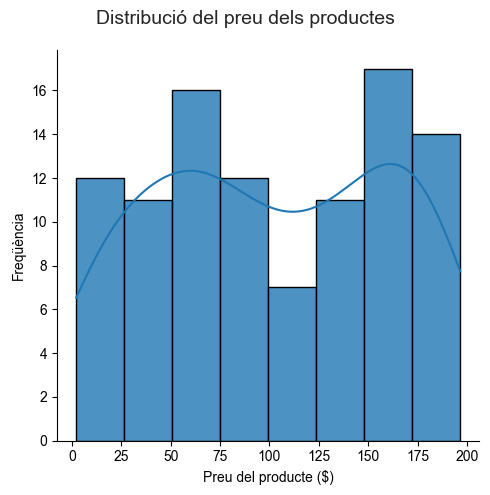

In [9]:
# Fem un histogram + density plot
product_price_dist = sns.displot(products['price'], kde=True, alpha=0.8)

# Change axis labels
product_price_dist.set_axis_labels("Preu del producte ($)", "Freqüència")

# Change grid style/color
sns.set_style("whitegrid", {'grid.color': '.85'})  # or use rc settings

# Change the title
product_price_dist.fig.suptitle("Distribució del preu dels productes", fontsize=14)

# Adjust layout so title fits
product_price_dist.fig.tight_layout()
product_price_dist.fig.subplots_adjust(top=0.9)

plt.show()


Veiem que tots els preus estan més o menys igual de representats. Veient això ens podríem preguntar: i no valdria la pena augmentar la gama de productes de baix preu per intentar arribar a més gent? Com a primera aproximació per veure si això podria ser una bona idea, podem mirar si els productes més econòmics es venen més. És a dir, hi ha una correlació entre el preu dels productes i les unitats venudes? Ho veurem a l'exercici 2.

#### <span style="color: rgb(230, 0, 126);"> Exercici 2: dues variables numèriques </span>

Hi ha relació entre el preu del producte i la quantitat d'unitats venudes?

In [10]:
# Necessito les taules products per transaction (per saber les unitats venudes), products (per saber el preu) i transactions (per eliminar les declined)

units_price = pd.merge(productspertransaction, products, how="left", left_on='product_id', right_on='id')
units_price = pd.merge(units_price, transactions[['id','declined','year']], how="left", left_on='transaction_id', right_on='id')
units_price = units_price.drop(columns=['id_x','id_y'])
units_price.head()
# result.shape[0] --- 1457 rows

,transaction_id,product_id,product_name,price,colour,weight,warehouse_id,declined,year
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4,0,2021
1,122DC333-E19F-D629-DCD8-9C54CF1EBB9A,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4,0,2021
2,1753A288-9FC1-52E6-5C39-A1FFB97B0D3A,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4,0,2021
3,1A6CECFB-2E3A-65A3-72D9-2FDB58A1E4BA,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4,0,2021
4,1EA2B262-D507-AD14-4374-4D532967113F,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4,0,2021


In [11]:
# Elimino les declined (em quedo només amb les no declined)
units_price = units_price[units_price['declined'] == 0]
units_price.shape[0] 

1236

In [12]:
# Em quedo únicament amb les transaccions de 2021
units_price = units_price[units_price['year'] == 2021]
units_price.shape[0] 

997

In [13]:
# Faig un df que contingui el count de cada product id i el preu d'aquell producte
units_price_corr = units_price.groupby(['product_id', 'price']).size().reset_index(name='count')
units_price_corr.head()

,product_id,price,count
0,1,161.11,41
1,2,9.24,43
2,3,171.13,34
3,5,171.22,34
4,7,63.33,37


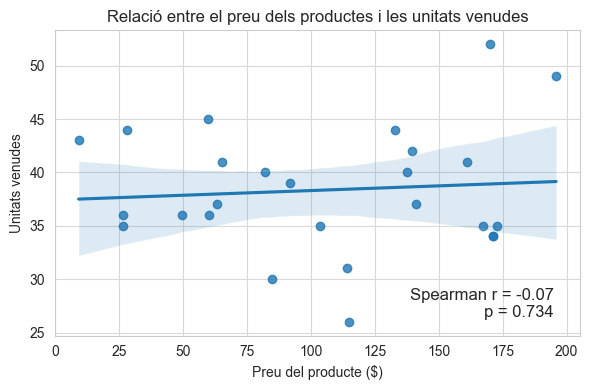

In [14]:
from scipy.stats import spearmanr

# Calculate the correlation
corr, p_value = spearmanr(units_price_corr['price'], units_price_corr['count'])
textstr = f"Spearman r = {corr:.2f}\np = {p_value:.3f}"

# Create plot
## Estableixo un tema
#sns.set_theme(style="whitegrid", context="notebook")
## Especifico les dimensions
plt.figure(figsize=(6, 4))
## Faig el gràfic en sí
sns.regplot(x=units_price_corr['price'], y=units_price_corr['count'])

# Axis labels and title
plt.xlabel("Preu del producte ($)")
plt.ylabel("Unitats venudes")
plt.title("Relació entre el preu dels productes i les unitats venudes")

# Add annotation in bottom-right corner
plt.annotate(
    textstr,
    xy=(0.95, 0.05), xycoords='axes fraction',
    ha='right', va='bottom',
    fontsize=12
)

plt.tight_layout()
plt.show()


Veiem que no hi ha una correlació significativa entre el preu dels productes i la quantitat d'unitats venudes. 

Amb aquesta informació, si com a empresa ens havia passat pel cap augmentar la nostra oferta de productes econòmics per vendre més, ara sabem que aquesta mesura no té per què funcionar, ja que es venen per igual els productes econòmics que els cars. 

#### <span style="color: rgb(230, 0, 126);"> Exercici 3: una variable categòrica </span>

Ara mirarem, del número potencial de transaccions, quantes s'han acabant duent a terme. És a dir, mirarem el percentatge de transaccions acceptades i rebutjades. Ens centrarem en l'any 2021. 

In [15]:
# Em quedo amb les transaccions de 2021
transactions_2021 = transactions[transactions['year'] == 2021]
# Compto el número de casos de cada
declined_accepted_2021 = transactions_2021['declined'].value_counts().reset_index()
declined_accepted_2021.columns = ['transaction_status', 'count']
declined_accepted_2021['transaction_status'] = declined_accepted_2021['transaction_status'].replace({0: 'acceptada', 1: 'rebutjada'})
declined_accepted_2021

,transaction_status,count
0,acceptada,405
1,rebutjada,74


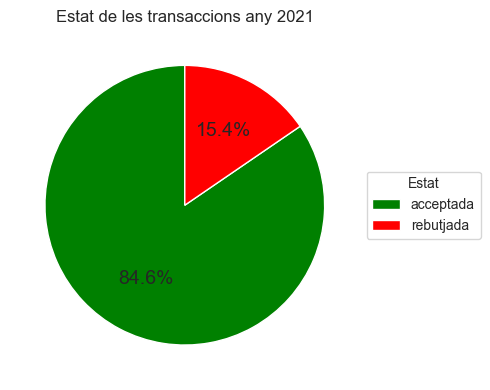

In [16]:
# Definim els colors personalitzats
colors = ['green' if status == 'acceptada' else 'red' for status in declined_accepted_2021['transaction_status']]

# Fem el plot
plt.figure(figsize=(6, 4))
declined_accepted_2021_pie = plt.pie(
    declined_accepted_2021['count'],
    labels=None,                     # No posem els noms aquí
    autopct='%1.1f%%',               # Mostra % al gràfic
    colors=colors,                   # Colors personalitzats
    startangle = 90,
    textprops={'fontsize': 14}       # Percentatges més grans
)

# Creem "elements visuals" per a la llegenda (un per cada categoria)
from matplotlib.patches import Patch 
legend_elements = [
    Patch(facecolor='green', label='acceptada'),
    Patch(facecolor='red', label='rebutjada')
]

# Afegim la llegenda amb aquests elements visuals
plt.legend(
    handles=legend_elements,
    title="Estat",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

# Títol i ajustos finals
plt.title('Estat de les transaccions any 2021')
plt.tight_layout()
plt.show()



Amb aquest gràfic veiem que un 15% de les transaccions acaben sent rebutjades. Hauríem d'investigar per què. Hi ha algun problema amb la plataforma de pagament? És una plataforma que utilitzem només en alguns països, la que està donant problemes? Ho sabrem a l'exercici 5.

#### <span style="color: rgb(230, 0, 126);"> Exercici 4: Una variable categòrica i una numèrica </span>

Volem veure les principals mesures de centralitat i dispersió de l'import de les transaccions i com varia a través dels paísos que estan en el top 5 de ventes totals. Per a això emprarem un boxplot. 

In [17]:
# Necessito les taules transaction i companies
transactions_company_2021 = pd.merge(transactions_2021[['id','amount','declined','business_id']], companies[['company_id','company_name','country']], how="left", left_on='business_id', right_on='company_id')
transactions_company_2021 = transactions_company_2021.drop(columns=['business_id'])
transactions_company_2021.head()
# transactions_company.shape[0]  --- 587

,id,amount,declined,company_id,company_name,country
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,466.92,0,b-2362,Lorem Eu Incorporated,Canada
1,0466A42E-47CF-8D24-FD01-C0B689713128,49.53,0,b-2302,Nunc Interdum Incorporated,Germany
2,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,279.93,0,b-2346,Ut Semper Foundation,Sweden
3,07A46D48-31A3-7E87-65B9-0DA902AD109F,340.87,1,b-2386,Lacus Quisque Associates,United States
4,09DE92CE-6F27-2BB7-13B5-9385B2B3B8E2,303.05,1,b-2298,Elit Etiam Laoreet Associates,Canada


In [18]:
# Elimino les declined
transactions_company_2021_accepted = transactions_company_2021[transactions_company_2021['declined'] == 0]
# Miro quins son els cinc països que més ingressos aporten
top5_countries = (transactions_company_2021_accepted.groupby('country')['amount'].sum().nlargest(5).index)
# Em quedo només amb les dades d'aquests cinc països. 
top5_data = transactions_company_2021_accepted[transactions_company_2021_accepted['country'].isin(top5_countries)]


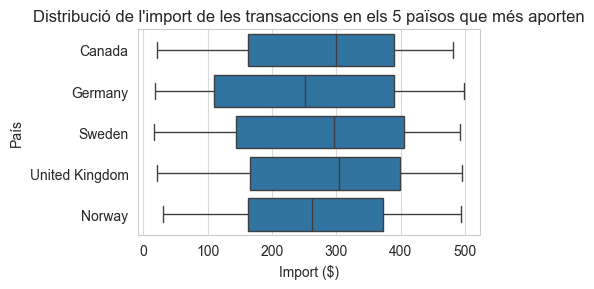

In [19]:
# Ara faig el boxplot amb la variable 'amount' separat per països. 
plt.figure(figsize=(5, 3))
sns.boxplot(data=top5_data, x='amount', y='country')

plt.title("Distribució de l'import de les transaccions en els 5 països que més aporten")
plt.xlabel("Import ($)")
plt.ylabel("País")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Veiem que els mínims i màxims són pràcticament iguals en tots els països i no hi ha outliers. La mediana d'Alemanya i Noruega és una mica més baixa que la de la resta. També podem observar que a Alemanya i Suècia hi ha més variabilitat en l'import de les transaccions mentre que a Noruega estan més concentrades al oltant dels 160-370$. 

#### <span style="color: rgb(230, 0, 126);"> Exercici 5: Dues variables categòriques </span>

Mirem quantes transaccions declined i accepted hi ha per cada país (només els que tenen més de 10 transaccions). 

In [20]:
# Comptar transaccions per país i declined
declined_accepted_by_country = transactions_company_2021.groupby(['country', 'declined']).size().unstack(fill_value=0) #això també es pot fer amb crosstab

# Reanomenar columnes
column_map = {0: 'Acceptades', 1: 'Rebutjades'}
declined_accepted_by_country = declined_accepted_by_country.rename(columns=column_map)

# Filtrar països amb més de 10 transaccions
declined_accepted_by_country['Total'] = declined_accepted_by_country['Acceptades'] + declined_accepted_by_country['Rebutjades']
declined_accepted_by_country = declined_accepted_by_country[declined_accepted_by_country['Total'] > 10]

# Ordenar per total descendent
declined_accepted_by_country = declined_accepted_by_country.sort_values(by='Total', ascending=False)

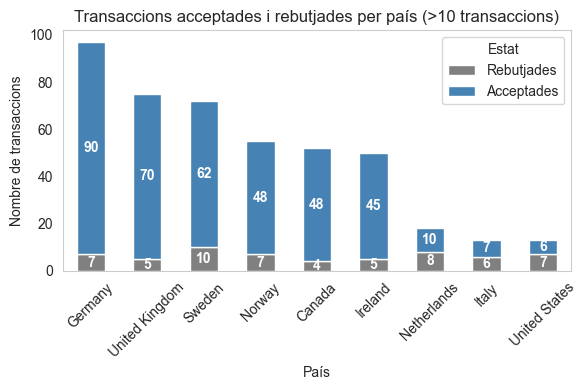

In [21]:
# Fem un gràfic de columnes apilades 
colors = ['grey', 'steelblue'] 
declined_accepted_by_country_barplot = declined_accepted_by_country[['Rebutjades', 'Acceptades']].plot(kind='bar', stacked=True, figsize=(6,4), color=colors)

# Afegir text a cada part de la barra
for i, (rej, acc) in enumerate(zip(declined_accepted_by_country['Rebutjades'], declined_accepted_by_country['Acceptades'])):
    # Text rebutjades (a la part inferior)
    if rej > 0:
        declined_accepted_by_country_barplot.text(i, rej / 2, str(rej), ha='center', va='center', color='white', fontweight='bold')
    # Text acceptades (a la part superior)
    if acc > 0:
        declined_accepted_by_country_barplot.text(i, rej + acc / 2, str(acc), ha='center', va='center', color='white', fontweight='bold')

plt.title('Transaccions acceptades i rebutjades per país (>10 transaccions)')
plt.xlabel('País')
plt.ylabel('Nombre de transaccions')
plt.xticks(rotation=45)
plt.legend(title='Estat')
declined_accepted_by_country_barplot.grid(False)
plt.tight_layout()
plt.show()

Amb aquest plot descartem que les transaccions rebutjades vinguin d'un sol país o conjunt de països. A més, podem veure que hi ha països amb una proporció de transaccions rebutjades molt gran (la barra blava i la grisa són pràcticament iguals). Convindria investigar què està passant en aquests casos. 

#### <span style="color: rgb(230, 0, 126);"> Exercici 6: Tres variables </span>

Mirem la relació entre edat del client i despesa mitjana en els tres països (Canada, UK, US)

In [22]:
# Necessitem users i transactions
users = users.rename(columns={'id': 'user_id'})
transactions_users = pd.merge(transactions[['id','amount','declined','user_id','year']], users[['user_id','age','country']], how="left", left_on='user_id', right_on='user_id')
# Em quedo amb les transaccions de 2021
transactions_users_2021 = transactions_users[transactions_users['year'] == 2021]
# Elimino les declined
transactions_users_2021_accepted = transactions_users_2021[transactions_users_2021['declined'] == 0]
transactions_users_2021_accepted.head()

,id,amount,declined,user_id,year,age,country
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,466.92,0,92,2021,37,United States
1,0466A42E-47CF-8D24-FD01-C0B689713128,49.53,0,170,2021,34,United Kingdom
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,279.93,0,92,2021,37,United States
12,1017AA59-3D5F-7A4C-1992-D151A8D1FA0A,447.11,0,267,2021,30,Canada
13,1026DA24-8929-31F1-8250-D7BAB05C13D2,465.31,0,92,2021,37,United States


In [23]:
# Ara necessito calcular l'import mitjà de les transaccions fetes per cada client
mean_amount_users_2021_accepted = (transactions_users_2021_accepted.groupby(['user_id','age','country'])['amount'].mean().reset_index(name='meanAmount'))
mean_amount_users_2021_accepted.head()


,user_id,age,country,meanAmount
0,61,31,United States,460.82
1,62,34,United States,133.39
2,64,33,United States,471.47
3,65,28,United States,268.48
4,66,33,United States,381.17


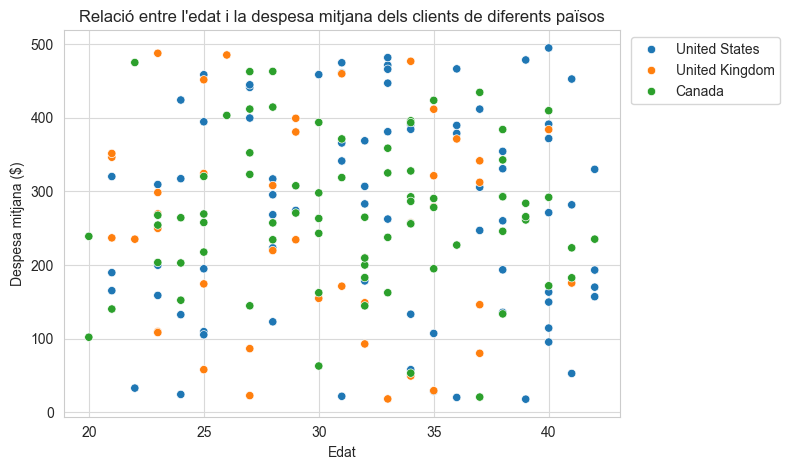

In [24]:
sns.scatterplot(
   x="age",
   y="meanAmount",
   data=mean_amount_users_2021_accepted,
   hue='country',
)

plt.xlabel("Edat")
plt.ylabel("Despesa mitjana ($)")
plt.title("Relació entre l'edat i la despesa mitjana dels clients de diferents països")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
plt.show()

Veiem que els punts estan uniformement distribuits a través de tot el plot. I això passa igual en els tres països. Així doncs, sembla que no hi ha una relació entre aquestes dues variables en cap dels països. 

#### <span style="color: rgb(230, 0, 126);"> Exercici 7: Graficar un Pairplot </span>

Farem el mateix que l'exercici anterior però emprant pairplot.

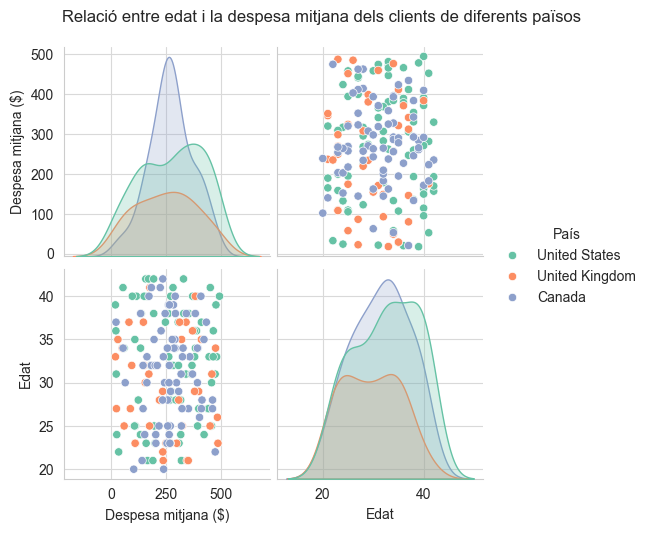

In [25]:
# Gráfico: Pairplot
# Ho farem amb un altre df on canviem els noms de les variables perquè, si ho hem de canviar directament al gràfic, serà un malson. 
df_renamed = mean_amount_users_2021_accepted.rename(
    columns={
        'meanAmount': 'Despesa mitjana ($)',
        'age': 'Edat',
        'country': 'País'
    }
)

sns.pairplot(
    df_renamed, 
    vars=['Despesa mitjana ($)', 'Edat'],
    hue='País',
    palette='Set2',
    diag_kind='kde'
)

plt.suptitle('Relació entre edat i la despesa mitjana dels clients de diferents països', y=1.05)
plt.show()

Els gràfics de distribució ens permeten observar que, si bé a US i UK, la despesa mitjana és molt variable i va de clients que gasten molt poc per transacció a clients que gasten molt, a Canadà gran part dels clients gasten de mitjana entre 200 i 350$.

Pel que fa a l'edat dels clients, observem que a UK estan distribuïts uniformement a través de totes les franges d'edat. D'altra banda, a Canadà els clients són de mitjana edat i a US, són més grans.

Respecte a la relació entre les dues variables, no s'observa cap patró. 

### <span style="color: rgb(230, 0, 126);"> Nivell 2</span>

#### <span style="color: rgb(230, 0, 126);"> Exercici 1: Correlació de totes les variables numèriques. </span>

In [26]:
# Mirem, en totes les taules que tenim, quines variables numèriques hi ha. Agafem només les que tenen sentit (per exemple, no ens quedarem amb latitude)

# Taules on hi ha informació numèrica rellevant: 
transactions.dtypes # amount
products.dtypes # price, ¿weight?

# A companies, credit_cards, credit_card_status, products_per_transaction, users no hi ha informació numèrica rellevant. 

# De les variables extra que hem calculat, podem emprar edat i unitats venudes de cada producte.  

id                int64
product_name     object
price           float64
colour           object
weight          float64
warehouse_id     object
dtype: object

Per tant, tenim: amount de la transacció, número de productes per transacció, edat de l'usuari, unitats venudes, pes del producte i preu del producte. 

Aquí hi ha variables que no té cap sentit correlacionar, com per exemple l'amount de la transacció i el pes del producte. Així doncs, farem dues matrius de correlació amb les variables que sí que té cert sentit ajuntar. 

A la primera matriu inclourem: amount de la transacció, número de productes per transacció, edat de l'usuari. No obstant, estic pensant que, si ho fem d'aquesta manera, hi ha una cosa que grinyola i és que si una mateixa persona ha fet més d'una compra, apareixerà sobrerepresentada. Si algú de 27 anys ha fet 50 transaccions, el valor de la correlació entre 27 anys i la resta de variables estarà molt esbiaixat per aquesta persona. Una possible solució és utilitzar el meanAmount, com en l'exercici anterior, i calcular també el mean número de productes per transacció. De totes maneres, aquesta última variable està condemnada al fracàs perquè són números molt baixos. 

A la segona matriu tindrem: unitats venudes, pes del producte i preu del producte. 

In [27]:
transactions_users_2021_accepted.head()

,id,amount,declined,user_id,year,age,country
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,466.92,0,92,2021,37,United States
1,0466A42E-47CF-8D24-FD01-C0B689713128,49.53,0,170,2021,34,United Kingdom
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,279.93,0,92,2021,37,United States
12,1017AA59-3D5F-7A4C-1992-D151A8D1FA0A,447.11,0,267,2021,30,Canada
13,1026DA24-8929-31F1-8250-D7BAB05C13D2,465.31,0,92,2021,37,United States


In [28]:
# Primera matriu 
products_per_transaction_count = productspertransaction.groupby(['transaction_id'])['product_id'].count().reset_index(name='number_items')
transactions_corr = pd.merge(transactions_users_2021_accepted, products_per_transaction_count, how="left", left_on='id', right_on='transaction_id')
transactions_corr = (transactions_corr.groupby(['user_id','age'])[['amount','number_items']].mean().reset_index())
# Ara hem de mirar la distribució de les variables per saber si hem de fer pearson o spearman
from scipy.stats import shapiro
stat, p = shapiro(transactions_corr['amount'])  
print(stat,p)  # p = .001 --> Reject the null hypothesis. Therefore, the distribution is not normal
stat, p = shapiro(transactions_corr['age'])  
print(stat,p)  # p < .001 --> Reject the null hypothesis. Therefore, the distribution is not normal
# number_items no cal ni mirar-ho

# Per tant, fem spearman

0.9744507783187841 0.0013914184235240632
0.9622463577365568 5.067674053720569e-05


In [29]:
# Matriu
transactions_corr_matrix = transactions_corr.drop(columns = "user_id").corr(method="spearman")
transactions_corr_matrix

,age,amount,number_items
age,1.000000,0.008461,-0.033532
amount,0.008461,1.000000,0.019203
number_items,-0.033532,0.019203,1.000000


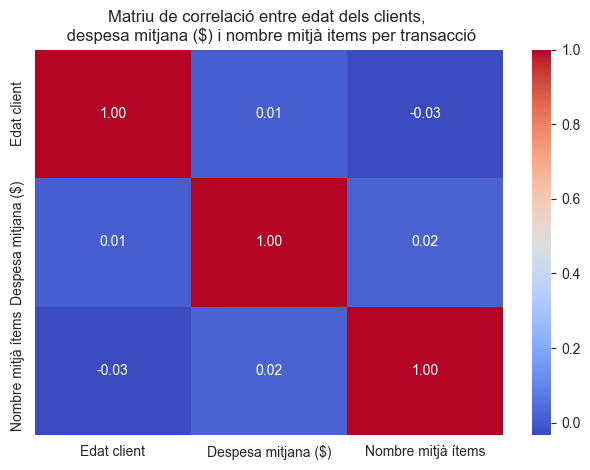

In [30]:
# Gràfic
rename_map = {
    'amount': 'Despesa mitjana ($)',
    'age': 'Edat client',
    'number_items': 'Nombre mitjà ítems'
}

df_renamed = transactions_corr_matrix.rename(columns=rename_map, index=rename_map)

sns.heatmap(df_renamed, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriu de correlació entre edat dels clients, \n despesa mitjana ($) i nombre mitjà items per transacció')
plt.tight_layout()
plt.show()

In [31]:
# Segona matriu
# Primer agafarem les variables d'interès de products i hi afegirem el count. 
product_corr = pd.merge(products[['id','weight','price']], units_price_corr[['product_id','count']],  how='left', left_on='id', right_on='product_id') 
product_corr = product_corr.drop(columns = ['product_id','id'])
product_corr.head()

# Tenim NaNs perquè hi ha alguns productes que no s'han venut. 


,weight,price,count
0,1.0,161.11,41.0
1,2.0,9.24,43.0
2,1.5,171.13,34.0
3,3.0,71.89,NaN
4,3.2,171.22,34.0


In [32]:
# Aquí també aplicarem spearman pq les dades no són normals. 
product_corr_matrix = product_corr.corr(method="spearman")
product_corr_matrix

,weight,price,count
weight,1.000000,0.110476,-0.297203
price,0.110476,1.000000,-0.069971
count,-0.297203,-0.069971,1.000000


In [33]:
#El method corr de pandas, per defecte, fa pairwise comparisons, utilitzant totes les dades disponibles per cada parell de variables (aka "pairwise complete observations").
# De totes maneres ho comprovarem. 

# Create a matrix with N per variable pair
n_matrix = product_corr.copy()

# Initialize an empty DataFrame to store counts
n_obs = pd.DataFrame(index=product_corr.columns, columns=product_corr.columns)

# Compute N for each pair
for col1 in product_corr.columns:
    for col2 in product_corr.columns:
        n = product_corr[[col1, col2]].dropna().shape[0]
        n_obs.loc[col1, col2] = n

n_obs = n_obs.astype(int)

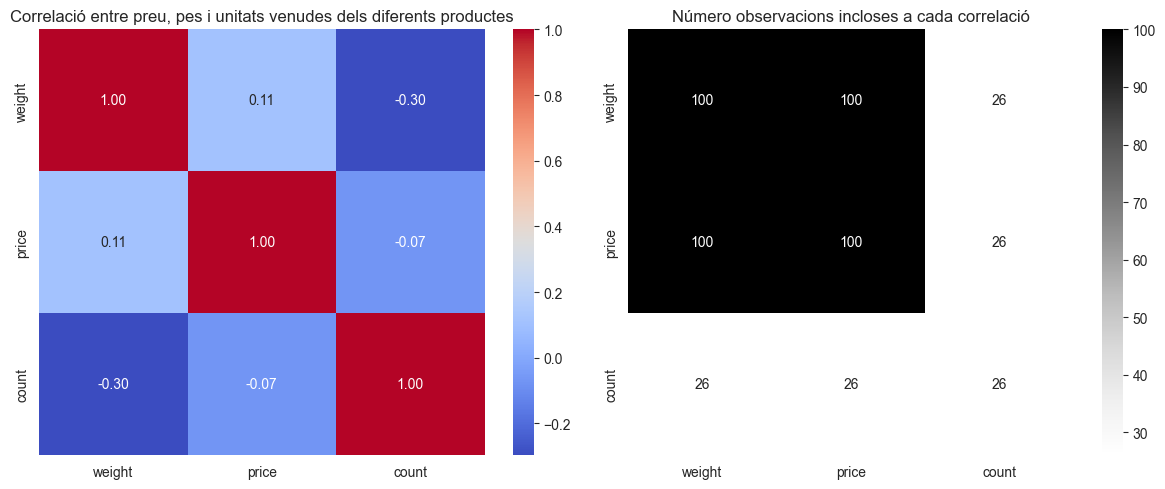

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriu de correlació 
sns.heatmap(product_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Correlació entre preu, pes i unitats venudes dels diferents productes')

# Matriu de mida de la mostra
sns.heatmap(n_obs, annot=True, cmap='Greys', fmt="d", ax=axes[1])
axes[1].set_title('Número observacions incloses a cada correlació')

plt.tight_layout()
plt.show()

In [35]:
# Vols dir que la correlació entre count i weight és significativa?

corr, p_value = spearmanr(product_corr['weight'], product_corr['count'], nan_policy='omit')
print(corr,p_value)

# La correlació no és significativa (p = .14)

-0.2972030125032284 0.1403559872679889


Així doncs, observem que no hi ha correlació significativa entre cap de les variables analitzades. 

Jo hagués esperat una correlació significativa entre edat i despesa mitjana per transacció, esperant que els clients més joves gastessin menys que els clients més grans. 

També hagués esperat una correlació significativa entre el preu dels productes i les unitats venudes, però en un exercici anterior ja ho havíem descartat. 

Per tant, res a destacar aquí. 

#### <span style="color: rgb(230, 0, 126);"> Exercici 2: Implementa un jointplot. </span>

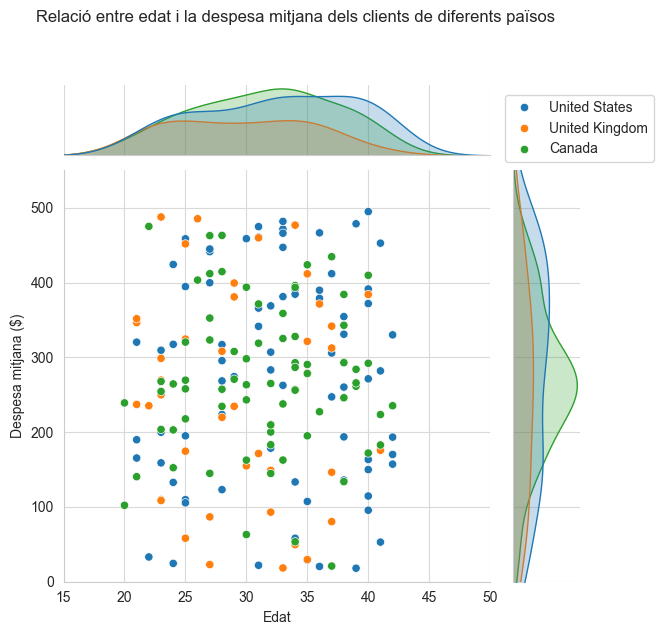

In [36]:
age_mean_amount_jointplot = sns.jointplot(data=mean_amount_users_2021_accepted, x="age", y="meanAmount", hue="country")
age_mean_amount_jointplot.ax_joint.set_xlim(15, 50)
age_mean_amount_jointplot.ax_joint.set_ylim(0, 550)

plt.xlabel("Edat")
plt.ylabel("Despesa mitjana ($)")
plt.suptitle('Relació entre edat i la despesa mitjana dels clients de diferents països', y=1.05)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.4, 1.2), loc='upper right')
plt.show()


De nou, no observem cap patró que faci pensar que hi ha una relació entre l'edat i la despesa mitjana de cada client (la qual cosa està corroborada per la correlació no significativa observada a l'exercici anterior). 

Els gràfics de distribució ens permeten observar de manera més clara que amb l'scatter plot que, si bé a US i UK, la despesa mitjana és molt variable i va de clients que gasten molt poc per transacció a clients que gasten molt, a Canadà gran part dels clients gasten de mitjana entre 200 i 350$.

Pel que fa a l'edat dels clients, observem que a UK estan distribuïts uniformement a través de totes les franges d'edat. D'altra banda, a Canadà els clients són de mitjana edat i a US, són més grans. Això ens podria donar una idea sobre quins mitjans de comunicació utilitzar a cada país per diversificar la nostra clientela. Per exemple, a US podríem intentar fer una campanya de publicitat a TikTok per intentar promocionar els nostres productes entre la gent jove (i més sabent que gasten el mateix que els grans perquè no hi ha correlació entre edat i despesa). 

### <span style="color: rgb(230, 0, 126);"> Nivell 3</span>

#### <span style="color: rgb(230, 0, 126);"> Exercici 1: Implementa un violinplot combinat amb un altre tipus de gràfic. </span>

C:\Users\gemma\AppData\Local\Temp\ipykernel_8304\1264143925.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=mean_amount_users_2021_accepted, x='country', y='meanAmount', palette='turbo',
C:\Users\gemma\AppData\Local\Temp\ipykernel_8304\1264143925.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y='meanAmount', data=mean_amount_users_2021_accepted, palette='turbo', width=0.3,


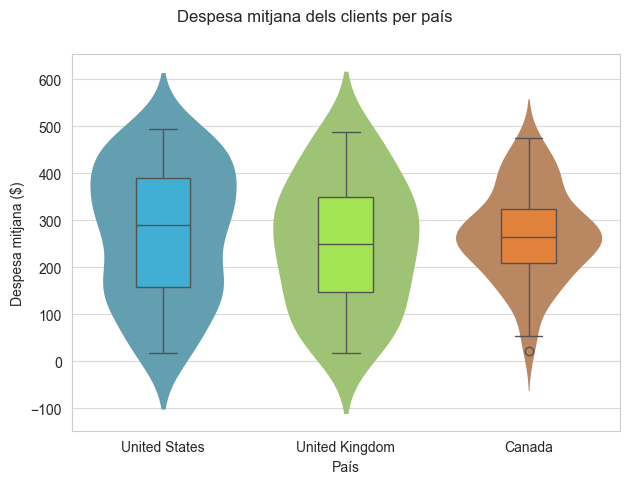

In [37]:
ax = sns.violinplot(data=mean_amount_users_2021_accepted, x='country', y='meanAmount', palette='turbo',
                    inner=None, linewidth=0, saturation=0.4)
sns.boxplot(x='country', y='meanAmount', data=mean_amount_users_2021_accepted, palette='turbo', width=0.3,
            boxprops={'zorder': 2}, ax=ax)


plt.xlabel("País")
plt.ylabel("Despesa mitjana ($)")
plt.suptitle('Despesa mitjana dels clients per país', y=1)
plt.tight_layout()
plt.show()

Tal com apuntàvem a l'exercici anterior, aquest gràfic ens permet observar que a US i UK la despesa mitjana dels cleints és molt variable i el rang és força ampli. En canvi, a Canadà la despesa mitjana té un rang més reduït: la despesa mitjana per client és de com a mínim 50$ però no supera els 480$ aprox. A més, la majoria de clients gasten de mitjana entre 200 i 350$ per transacció.

Si analitzem més en detall US i UK, observem que a US la despesa mitjana per transacció és més elevada que a UK (la mediana es més alta).

#### <span style="color: rgb(230, 0, 126);"> Exercici 2: Genera un FacetGrid per a visualitzar múltiples aspectes de les dades simultàniament. </span>

Plotejarem el nombre total de transaccions, l'amount total i el mean amount per cada país.

In [38]:
# Calculem les dades que volem protejar
agg_df = transactions_company_2021_accepted.groupby('country').agg(
    total_transactions=('id', 'count'),
    total_amount=('amount', 'sum'),
    mean_amount=('amount', 'mean'),
    std_amount=('amount', 'std')
).reset_index()

# Per fer el plot necessitem aquestes dades en long format
plot_df = agg_df.melt(
    id_vars='country',
    value_vars=['total_transactions', 'total_amount', 'mean_amount'],
    var_name='metric',
    value_name='value'
)

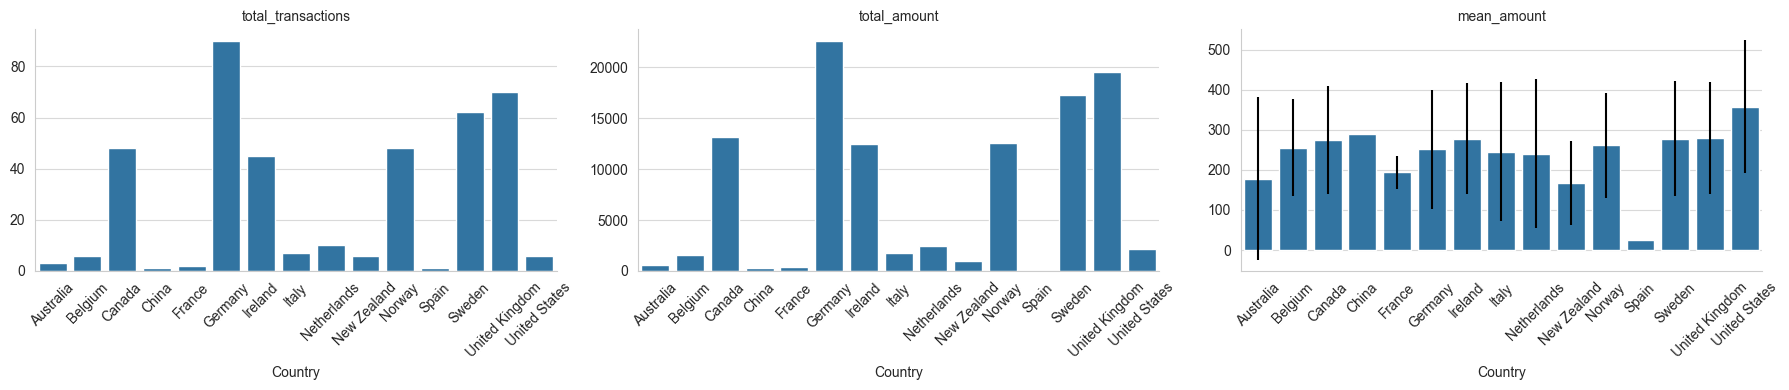

In [39]:
# Fem el plot
g = sns.FacetGrid(data=plot_df, col='metric', sharey=False, height=4, aspect=1.5)

def barplot_with_error(data, **kwargs): 
    metric = data['metric'].iloc[0]
    if metric == 'mean_amount':
        # Merge std back in
        stds = agg_df[['country', 'std_amount']]
        data = data.merge(stds, on='country')
        sns.barplot(data=data, x='country', y='value', yerr=data['std_amount'], **kwargs)
    else:
        sns.barplot(data=data, x='country', y='value', **kwargs)

g.map_dataframe(barplot_with_error)
g.set_axis_labels("Country", "")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)

plt.tight_layout()
plt.show()